In [1]:
import sys
sys.path.append('../')

In [5]:
from src.data.exact.server import xmls
from src.data.exact.resources import metadata

from src.data.exact.splits import Splits, HasProstateMaskFilter, InvolvementThresholdFilter
splits = Splits(
    cohort_specifier=['UVA600', 'CRCEO428'], 
    merge_test_centers=True,
    merge_val_centers=True, 
    undersample_benign_eval=True
)
splits.apply_filters(
    HasProstateMaskFilter(),
    InvolvementThresholdFilter(0.4)
)

all_cores = splits.get_all()

In [13]:
from tqdm.auto import tqdm

all_parameters = []

for core in tqdm(all_cores): 

    xmls.download_vxml(core, 'test.vxml')
    params = xmls._flatten_dict(xmls._parse_all_parameters('test.vxml'))
    params['core_specifier'] = core
    all_parameters.append(params)

import pandas as pd
df = pd.DataFrame(all_parameters)
df.describe().loc['unique']

  0%|          | 0/796 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
# SAVE TO CSV
df.to_csv(
    'imaging_parameters.csv',
)
df = pd.read_csv('../data/imaging_parameters.csv', index_col=0)

In [39]:
# Only keep columns with many unique values
columns_with_many_unique_values = []
for column in df.columns: 
    if len(df[column].unique()) > 2: 
        columns_with_many_unique_values.append(column)

In [51]:
# Look at the TGC values
tgc = df[columns_with_many_unique_values]['Global.Tgc/Control']

import numpy as np

def decode(encoded_str):
    out = encoded_str.replace('\'', '').removeprefix('[').removesuffix(']').split(',')
    out = [float(x) for x in out]
    return out

tgcs = np.stack(list(tgc.apply(decode)))

Text(0.5, 1.0, 'PCA projection of the TGCs')

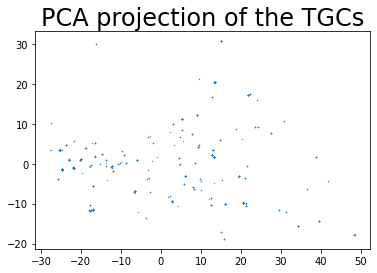

In [64]:
# Is there a pattern in the TGCs?

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedding = pca.fit_transform(tgcs)

import matplotlib.pyplot as plt
plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA projection of the TGCs', fontsize=24)

In [68]:
pca.get_covariance()

AttributeError: 'numpy.ndarray' object has no attribute 'diag'

Conclusion - No real pattern in the TGC values.

In [35]:
len(df)

796

In [22]:
count = df.describe().loc['count']
[column for column in count if count != len(df)]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [26]:
cols = [column for column in count.index if count[column] != len(df)]

In [29]:
import json
import os 

class DictFileWrapper:
    def __init__(self, path): 
        self.path = path
        if os.path.isfile(path): 
            self._open()
        else: 
            self._dict = {}
    
    def _open(self): 
        with open(self.path, 'r') as f: 
            self._dict = json.loads(f.read())

    def _save(self): 
        with open(self.path, 'w') as f: 
            f.write(json.dumps(self._dict))

    def __getitem__(self, key):
        return self._dict.__getitem__(key)

    def __setitem__(self, key, value):
        self._dict.__setitem__(key, value)
        self._save()

    def __delitem__(self, key):
        self._dict.__delitem__(key)
        self._save()
    

In [31]:
d = DictFileWrapper('params.json')

from tqdm.auto import tqdm
for core_specifier in tqdm(list(m['core_specifier'])): 
    if core_specifier in d._dict: continue
    try: 
        xmls.download_vxml(core_specifier, 'test.vxml')
        params = xmls._flatten_dict(xmls._parse_all_parameters('test.vxml'))
        d[core_specifier] = params
    except: 
        pass

  0%|          | 0/6607 [00:00<?, ?it/s]

In [9]:
params

{'Global.Exam/Exam-Type': '2',
 'Global.Exam/Transverse-View-Type': '1',
 'Global.Transducer-General/Center-Frequency': '20',
 'Global.Exam/Measurement-Type': '0',
 'Global.Settings/Version-FW': '1.4.52',
 'Global.HwTrackingArm/Set-Home': 'true',
 'Global.Settings/Package': 'VSI_GenericPackage.sxml',
 'Global.Settings/Application-System': 'Prostate',
 'Global.Transducer-General/Show-Message': 'true',
 'Global.Settings/Mode': '1',
 'Global.Settings/Version-Software-Current': '1.1.6.933',
 'Global.Settings/RF-Feature': 'true',
 'Global.Tgc/Control': ['0.588235294117649',
  '13.0588235294118',
  '20.8235294117647',
  '27.8823529411765',
  '27.8823529411765',
  '25.0588235294118',
  '17.2941176470588',
  '8.8235294117647'],
 'Global.Settings/Saved-Frame': 'false',
 'Global.Transducer-General/Length-Azimuth': '46.08',
 'Global.Transducer-General/Name': 'IMX-512',
 'Global.Transducer-General/Rotation-Z': '0',
 'Global.HwTrackingArm/Arm-Param': '00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00

In [7]:
params

{'Global': {'Exam/Exam-Type': '2',
  'Exam/Transverse-View-Type': '1',
  'Transducer-General/Center-Frequency': '20',
  'Exam/Measurement-Type': '0',
  'Settings/Version-FW': '1.4.52',
  'HwTrackingArm/Set-Home': 'true',
  'Settings/Package': 'VSI_GenericPackage.sxml',
  'Settings/Application-System': 'Prostate',
  'Transducer-General/Show-Message': 'true',
  'Settings/Mode': '1',
  'Settings/Version-Software-Current': '1.1.6.933',
  'Settings/RF-Feature': 'true',
  'Tgc/Control': ['0.588235294117649',
   '13.0588235294118',
   '20.8235294117647',
   '27.8823529411765',
   '27.8823529411765',
   '25.0588235294118',
   '17.2941176470588',
   '8.8235294117647'],
  'Settings/Saved-Frame': 'false',
  'Transducer-General/Length-Azimuth': '46.08',
  'Transducer-General/Name': 'IMX-512',
  'Transducer-General/Rotation-Z': '0',
  'HwTrackingArm/Arm-Param': '00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 

In [5]:
xmls.download_vxml(m['core_specifier'].iloc[0], 'target.xml')

In [7]:
xmls.get_path_to_vxml(m['core_specifier'].iloc[0])


'/med-i_data/exact_prostate_segemnts/vxmls/VXMLs/Benign/CRCEO-0004_LML_Benign.vxml'

In [6]:
xmls.get_settings_dataframe(list(m['core_specifier']))

  1%|          | 73/6607 [01:07<1:40:41,  1.08it/s] 


KeyboardInterrupt: 

In [2]:
import sys
sys.path.append('../')

from src.data.exact.resources import metadata
m = metadata()
from src.data.exact.server import load_by_core_specifier

iq = load_by_core_specifier(m['core_specifier'].iloc[0])

In [7]:
from tqdm.notebook import tqdm
import paramiko

shapes = []
for core_specifier in tqdm(list(m['core_specifier'])): 
    try: 
        iq = load_by_core_specifier(core_specifier)
        shape = iq['I'].shape
        shapes.append({
            'iq_shape': shape, 
            'core_specifier': core_specifier
        })
    except paramiko.SSHException: 
        print('warning: ssh error detected')

import pandas as pd 
shapes_df = pd.DataFrame(shapes)
shapes_df.to_csv('iq_data_shapes.csv')

  0%|          | 0/6607 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
iq['I'].shape

(1256, 512, 6)